In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline

from skimage.measure import compare_ssim
from sklearn.model_selection import train_test_split

# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4503601583487662224
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6602251960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5682369784991728770
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
"""
    Peak Signal-to-Noise Ratio:
         > 40dB: great
        30~40dB: good
        20~30dB: bad
         < 20dB: worse
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def SSIM(img1, img2, _range=None, multichannel=False):
    return compare_ssim(img1, img2, data_range=_range, multichannel=multichannel)

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
"""
    custom loss function
"""
"""
def customLoss(layer):
    def loss(y_true, y_pred):
        return keras_backend
    return loss
"""
# Keras lib: https://github.com/keras-team/keras-contrib
# Combine loss: https://stackoverflow.com/questions/51705464/keras-tensorflow-combined-loss-function-for-single-output
# TF example: https://stackoverflow.com/questions/52798540/working-with-ssim-loss-function-in-tensorflow-for-rgb-images
# MSE source: https://github.com/keras-team/keras/blob/master/keras/losses.py
# TF SSIM: https://www.tensorflow.org/api_docs/python/tf/image/ssim
#To-Notice: SSIM on RGB will be average

# Customize loss for multi parameters: https://github.com/keras-team/keras/issues/2121

# keras github mse problem for customize loss layer ( axis=-1)
#https://stackoverflow.com/questions/41707621/keras-mean-squared-error-loss-layer

#tensorflow mse
#https://www.tensorflow.org/api_docs/python/tf/losses/mean_squared_error

#https://stackoverflow.com/questions/50124158/keras-loss-function-with-additional-dynamic-parameter
"""
https://www.mathworks.com/matlabcentral/answers/231932-is-this-how-to-calculate-mean-square-error-for-two-images
function MSE= MSE(lena, image_new);
[M, N] = size(lena);
error = lena - (image_new);
MSE = sum(sum(error .* error)) / (M * N);
disp(MSE);
end
"""

import keras.backend as K

def testMSE(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1) + DSSIMObjective(y_true, y_pred)
    return (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true))

def MSE_Plus_SSIM_Loss(y_true, y_pred, y_true_32, y_true_64, y_true_128, y_true_256, y_pred_32, y_pred_64, y_pred_128, y_pred_256): 
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0))
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0))
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0))
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0))
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0))
    )
    
    loss2 = (
        K.mean(K.square(y_pred - y_true))
        + K.mean(K.square(y_pred_32 - y_true_32))
        + K.mean(K.square(y_pred_64 - y_true_64))
        + K.mean(K.square(y_pred_128 - y_true_128))
        + K.mean(K.square(y_pred_256 - y_true_256))
    )
    
    """
    loss = (
        (1.0 - tf.image.ssim(y_pred, y_true, 1.0)) + K.mean(K.square(y_pred - y_true), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_16, y_true_16, 1.0)) + K.mean(K.square(y_pred_16 - y_true_16), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_32, y_true_32, 1.0)) + K.mean(K.square(y_pred_32 - y_true_32), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_64, y_true_64, 1.0)) + K.mean(K.square(y_pred_64 - y_true_64), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_128, y_true_128, 1.0)) + K.mean(K.square(y_pred_128 - y_true_128), axis=-1)
        + (1.0 - tf.image.ssim(y_pred_256, y_true_256, 1.0)) + K.mean(K.square(y_pred_256 - y_true_256), axis=-1)
    )"""
    return loss + loss2

In [3]:
"""
    basic CNN model
"""
def SRCNN(pretrained_weights=None):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(512, 512, 1),padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(1, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    if(pretrained_weights):
            model.load_weights(pretrained_weights)

    return model

model = SRCNN()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 512, 1)       577       
Total params: 112,001
Trainable params: 112,001
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
"""
    load training data
"""
import gc

dataY = np.zeros((4000,512, 512))

count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + ".png", cv2.IMREAD_GRAYSCALE)
    dataY[count] = img
    dataY[count+1] = img
    dataY[count+2] = img
    dataY[count+3] = img
    dataY[count+4] = img
    count += 5
                 
dataY = dataY.reshape(-1, 512, 512, 1)
dataY = dataY.astype('float32') / 255

In [5]:
"""
    noise image
"""
X = np.zeros((4000,512, 512))
count = 0
for i in range(1, 801):
    picture = f'{i:#04d}'
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise50.png", cv2.IMREAD_GRAYSCALE)
    X[count] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise60.png", cv2.IMREAD_GRAYSCALE)
    X[count+1] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise70.png", cv2.IMREAD_GRAYSCALE)
    X[count+2] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise80.png", cv2.IMREAD_GRAYSCALE)
    X[count+3] = img
    img = cv2.imread("../../div2k_train_gray/" + picture + "_noise90.png", cv2.IMREAD_GRAYSCALE)
    X[count+4] = img
    count += 5

X = X.reshape(-1, 512, 512, 1)
X = X.astype('float32') / 255
                 
X_train, X_test, y_train, y_test = train_test_split(X, dataY, test_size=0.3, random_state=41)

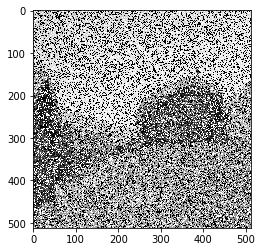

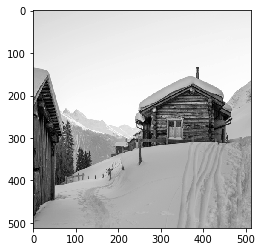

7.874676585197449


In [6]:
X_train = X_train.reshape(-1, 512, 512)
y_train = y_train.reshape(-1, 512, 512)
img = X_train[1]
plt.imshow(img, cmap="gray")
plt.show()
img = y_train[1]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(y_train[1], X_train[1]) )

In [7]:
X_train = X_train.reshape(-1, 512, 512, 1)
y_train = y_train.reshape(-1, 512, 512, 1)

modelCheck = ModelCheckpoint('SRCNN_{epoch:04d}.h5', save_weights_only=True, save_best_only=True)
#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
earlyStop = EarlyStopping(monitor='val_loss', patience=20)
history = History()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=500,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[modelCheck, history])

Instructions for updating:
Use tf.cast instead.
Train on 2800 samples, validate on 1200 samples
Epoch 1/500
2800/2800 [==============================] - 134s 48ms/step - loss: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0000e+00
Epoch 2/500
2800/2800 [==============================] - 131s 47ms/step - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 3/500
2800/2800 [==============================] - 130s 46ms/step - loss: 0.0237 - acc: 0.0000e+00 - val_loss: 0.0244 - val_acc: 0.0000e+00
Epoch 4/500
2800/2800 [==============================] - 130s 46ms/step - loss: 0.0231 - acc: 0.0000e+00 - val_loss: 0.0212 - val_acc: 0.0000e+00
Epoch 5/500
2800/2800 [==============================] - 130s 47ms/step - loss: 0.0223 - acc: 0.0000e+00 - val_loss: 0.0193 - val_acc: 0.0000e+00
Epoch 6/500
2800/2800 [==============================] - 130s 46ms/step - loss: 0.0193 - acc: 0.0000e+00 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 7/500
2800/2800 [=====

KeyboardInterrupt: 

== SRCNN accuracy ==
Train loss: 0.001921364371664822
Train accuracy: 0.0
Test loss: 0.0018399133409063022
Test accuracy: 0.0


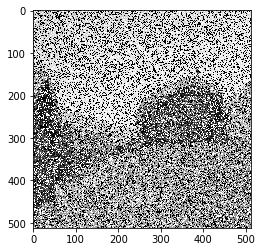

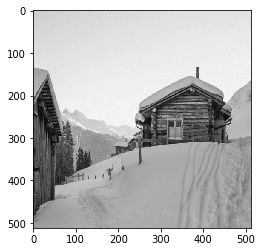

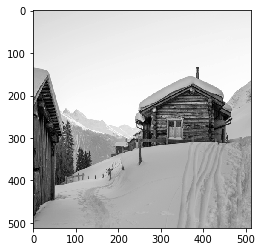

35.95065355300903
29.043878987431526
0.9815525097453992
0.8591862054007665
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


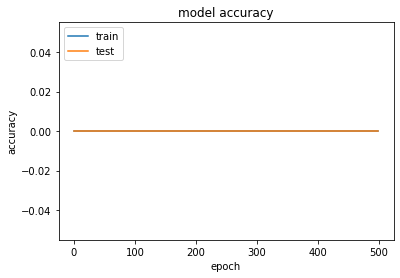

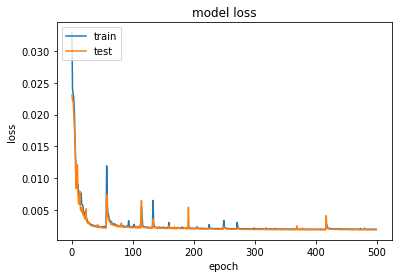

In [10]:
print("== SRCNN accuracy ==")
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model.predict(X_train)
result = result.reshape(-1, 512, 512)
X_train = X_train.reshape(-1, 512, 512)
y_train = y_train.reshape(-1, 512, 512)
img = X_train[1]
plt.imshow(img, cmap="gray")
plt.show()
# show the image
img = result[1]
plt.imshow(img, cmap="gray")
plt.show()
img = y_train[1]
plt.imshow(img, cmap="gray")
plt.show()
print(PSNR(y_train[1], result[1]) )

totalPSNR = 0
for i in range(2800):
    totalPSNR += PSNR(y_train[i], result[i])
#print(totalPSNR)
print(totalPSNR / 2800)

totalSSIM = 0
for i in range(2800):
    totalSSIM += SSIM(y_train[i], result[i], 1.0)
#print(totalSSIM)
print(SSIM(y_train[1], result[1]))
print(totalSSIM / 2800)

printHistory(history)